Accuracy: 0.8767142073505211
Confusion Matrix:
 [[ 228  413]
 [ 486 6165]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.32      0.36      0.34       641
        Good       0.94      0.93      0.93      6651

    accuracy                           0.88      7292
   macro avg       0.63      0.64      0.63      7292
weighted avg       0.88      0.88      0.88      7292



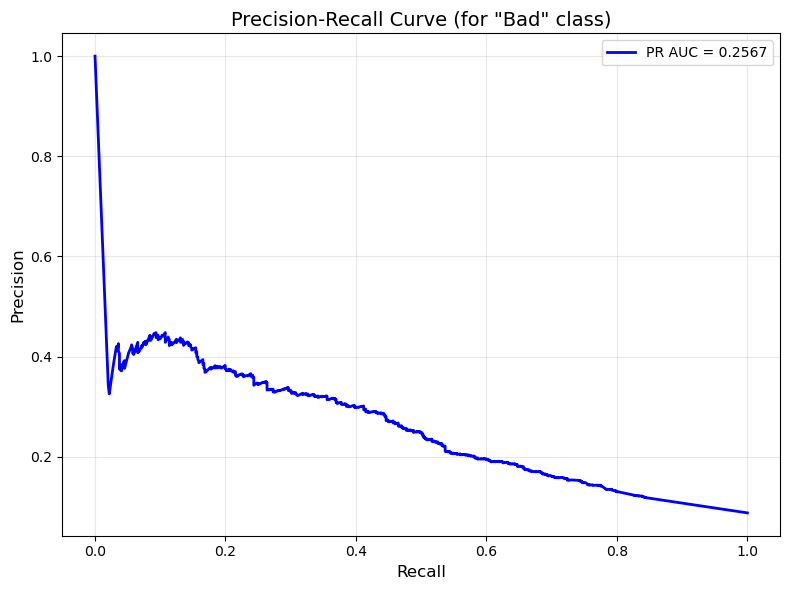

                                         Feature  Importance
8                                            age    0.140765
10                             log_annual_income    0.086441
3                                  annual_income    0.085192
11                            log_years_employed    0.083477
9                                 years_employed    0.082862
7                                    family_size    0.075560
16               education_type_Higher education    0.035035
2                                     own_realty    0.028324
20                         family_status_Married    0.025792
19  education_type_Secondary / secondary special    0.023325
15                           income_type_Working    0.021084
40                             occupation_Others    0.020776
5                                          phone    0.020109
1                                        own_car    0.019538
4                                     work_phone    0.019017
0                       

/var/folders/yk/vlzfvr0952z_d1jtd2jgn2tm0000gn/T/ipykernel_8796/373417730.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


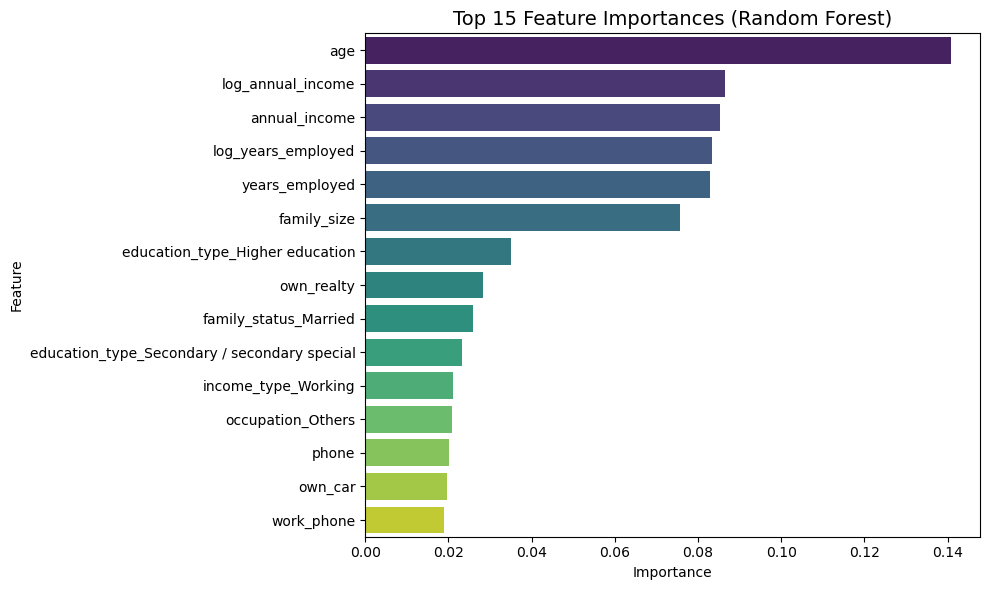

In [62]:
# Random Forest Base Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_curve, auc
)

# Load the training and testing datasets
train_set = pd.read_csv('train_set.csv')
test_set = pd.read_csv('test_set.csv')

# Separate features and labels
X_train = train_set.drop('credit_status', axis=1)
y_train = train_set['credit_status']
X_test = test_set.drop(['credit_status', 'id'], axis=1)
y_test = test_set['credit_status']

# Build and train the Random Forest model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Encode labels to 0 = Bad, 1 = Good
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Identify the encoded value for "Bad" (should be 0)
bad_index = list(le.classes_).index('Bad')  # Usually 0

# Predict probabilities for "Bad" class
y_scores = rf.predict_proba(X_test)[:, bad_index]

# Compute Precision-Recall curve using correct pos_label
precision, recall, _ = precision_recall_curve(y_test_encoded, y_scores, pos_label=bad_index)
pr_auc = auc(recall, precision)

# Plot PRC
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', linewidth=2, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve (for "Bad" class)', fontsize=14)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature Importance Plot
importances = rf.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
print(feat_imp_df)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Accuracy: 0.8764399341744378

Confusion Matrix:
 [[ 125  516]
 [ 385 6266]]

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.20      0.22       641
           1       0.92      0.94      0.93      6651

    accuracy                           0.88      7292
   macro avg       0.58      0.57      0.58      7292
weighted avg       0.86      0.88      0.87      7292



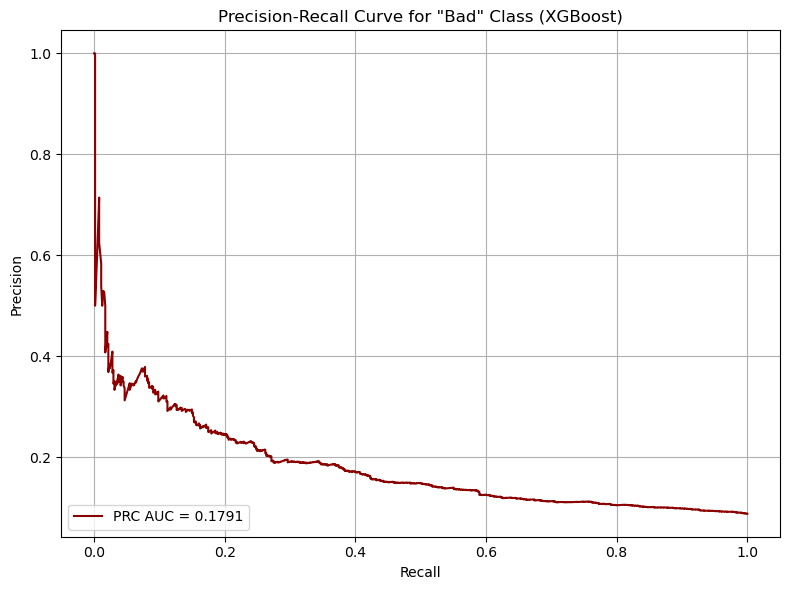

In [81]:
# XGBoost Base Model

import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load datasets
train_df = pd.read_csv("train_set.csv")
test_df = pd.read_csv("test_set.csv")

# Define feature columns (all except 'id' and 'credit_status')
feature_columns = [col for col in train_df.columns if col not in ["credit_status", "id"]]

# Split features and target
X_train = train_df[feature_columns]
y_train = LabelEncoder().fit_transform(train_df["credit_status"])
X_test = test_df[feature_columns]
y_test = LabelEncoder().fit_transform(test_df["credit_status"])

# Initialize and train XGBoost classifier
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predict on test set
y_pred = xgb.predict(X_test)

# Attach predictions to customer IDs
results_df = test_df[["id"]].copy()
results_df["predicted_credit_status"] = y_pred

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Get predicted probabilities for 'Bad' class
y_probs = xgb.predict_proba(X_test)[:, bad_index]

# Convert true labels to binary (1 = Bad, 0 = Good)
y_test_binary = (y_test == bad_index).astype(int)

# Compute PRC curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_probs)
prc_auc = auc(recall, precision)

# Plot PRC
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkred')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for "Bad" Class (XGBoost)')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

Accuracy: 0.8827482172243555

Confusion Matrix:
 [[ 201  440]
 [ 415 6236]]

Classification Report:
               precision    recall  f1-score   support

         Bad       0.33      0.31      0.32       641
        Good       0.93      0.94      0.94      6651

    accuracy                           0.88      7292
   macro avg       0.63      0.63      0.63      7292
weighted avg       0.88      0.88      0.88      7292


📈 PRC AUC (Bad class): 0.2444


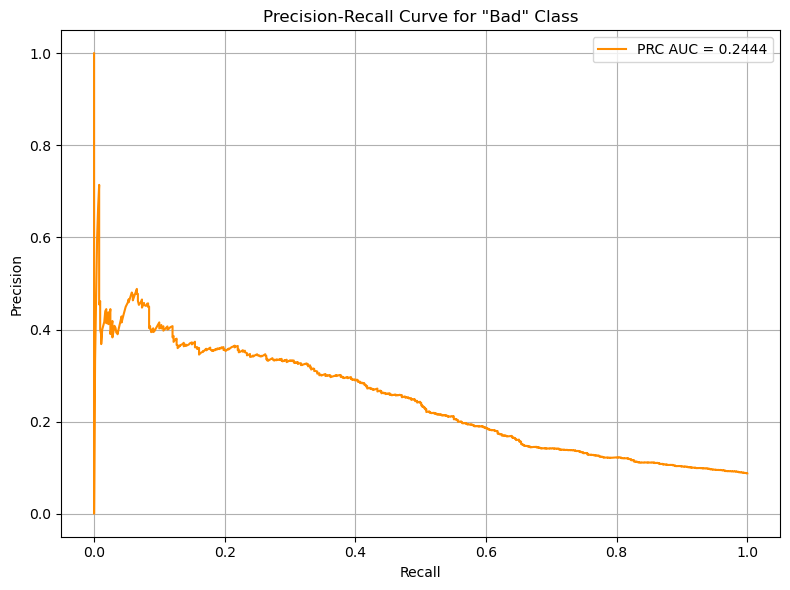

In [83]:
# Stacking Base Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_curve, average_precision_score
)

# Load datasets
train_df = pd.read_csv("train_set.csv")
test_df = pd.read_csv("test_set.csv")

# Define features and target
feature_columns = [col for col in train_df.columns if col not in ["credit_status", "id"]]
X_train = train_df[feature_columns]
X_test = test_df[feature_columns]

# Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(train_df["credit_status"])
y_test = le.transform(test_df["credit_status"])
bad_index = list(le.classes_).index("Bad")  # index for "Bad" class (usually 0)

# Define base models
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb = XGBClassifier(eval_metric='logloss')

# Create Stacking Ensemble
stacking_model = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=LogisticRegression(max_iter=2000),
    passthrough=True,
    n_jobs=-1
)

# Train and predict
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

# Get predicted probabilities
y_probs = stacking_model.predict_proba(X_test)[:, bad_index]

# Evaluate PRC AUC for the "Bad" class
precision, recall, _ = precision_recall_curve(y_test, y_probs, pos_label=bad_index)
prc_auc = average_precision_score(y_test, y_probs, pos_label=bad_index)

# Output results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print(f"\n📈 PRC AUC (Bad class): {prc_auc:.4f}")

# Plot PRC curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for "Bad" Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 48 candidates, totalling 144 fits
✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

🔎 Evaluating thresholds...

Threshold: 0.00
Precision (Bad): 0.1183
Recall (Bad):    0.7457
F1 Score (Bad):  0.2043

Threshold: 0.05
Precision (Bad): 0.1529
Recall (Bad):    0.6240
F1 Score (Bad):  0.2456

Threshold: 0.10
Precision (Bad): 0.1690
Recall (Bad):    0.5757
F1 Score (Bad):  0.2613

Threshold: 0.15
Precision (Bad): 0.1810
Recall (Bad):    0.5257
F1 Score (Bad):  0.2693

Threshold: 0.20
Precision (Bad): 0.1905
Recall (Bad):    0.4587
F1 Score (Bad):  0.2692

Threshold: 0.25
Precision (Bad): 0.2057
Recall (Bad):    0.4197
F1 Score (Bad):  0.2760

Threshold: 0.30
Precision (Bad): 0.2201
Recall (Bad):    0.3697
F1 Score (Bad):  0.2759

Threshold: 0.35
Precision (Bad): 0.2223
Recall (Bad):    0.3198
F1 Score (Bad):  0.2623

Threshold: 0.40
Precision (Bad): 0.231

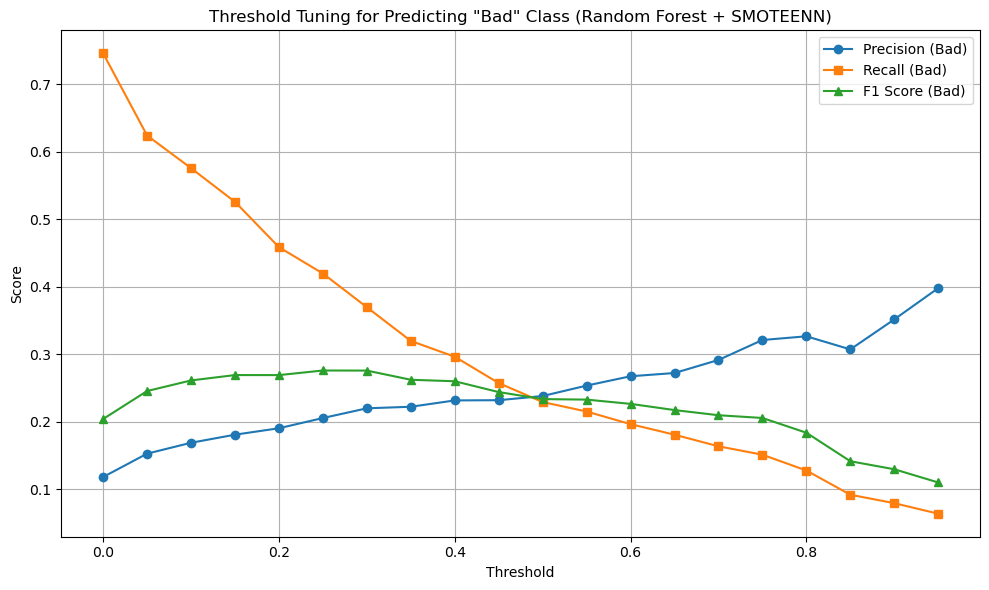


📌 Best threshold based on F1 Score: 0.25
Final Evaluation:

Accuracy: 0.806500274273176
Confusion Matrix:
 [[ 269  372]
 [1039 5612]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.21      0.42      0.28       641
        Good       0.94      0.84      0.89      6651

    accuracy                           0.81      7292
   macro avg       0.57      0.63      0.58      7292
weighted avg       0.87      0.81      0.83      7292



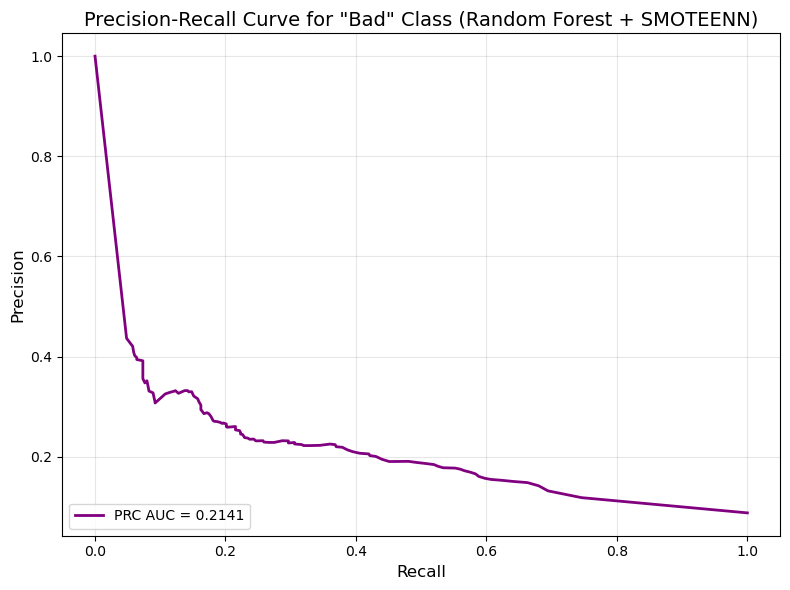

In [71]:
# Random Forest Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, make_scorer
)
from imblearn.combine import SMOTEENN

# Load the training and testing datasets
train_set = pd.read_csv('train_set.csv')
test_set = pd.read_csv('test_set.csv')

# Separate features and labels
X_train = train_set.drop(['credit_status'], axis=1)
y_train = train_set['credit_status']
X_test = test_set.drop(['credit_status', 'id'], axis=1)
y_test = test_set['credit_status']

# Apply SMOTEENN to handle class imbalance
smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X_train, y_train)

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

# Use F1 Score for "Bad" class as the scoring metric
scorer = make_scorer(f1_score, pos_label='Bad')

# Grid search with Random Forest
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Train model
grid_search.fit(X_resampled, y_resampled)
best_rf = grid_search.best_estimator_

print("✅ Best Parameters:", grid_search.best_params_)

# Get predicted probabilities for test set
y_probs = best_rf.predict_proba(X_test)

# Index of the 'Bad' class
bad_index = list(best_rf.classes_).index('Bad')

# Evaluate different thresholds
thresholds = np.arange(0, 1, 0.05)
precisions = []
recalls = []
f1s = []

print("\n🔎 Evaluating thresholds...\n")
for threshold in thresholds:
    y_pred = np.where(y_probs[:, bad_index] > threshold, 'Bad', 'Good')
    
    precision = precision_score(y_test, y_pred, pos_label='Bad', zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label='Bad', zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label='Bad', zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    print(f"Threshold: {threshold:.2f}")
    print(f"Precision (Bad): {precision:.4f}")
    print(f"Recall (Bad):    {recall:.4f}")
    print(f"F1 Score (Bad):  {f1:.4f}\n")

# Plot precision-recall-f1 tradeoff
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision (Bad)', marker='o')
plt.plot(thresholds, recalls, label='Recall (Bad)', marker='s')
plt.plot(thresholds, f1s, label='F1 Score (Bad)', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning for Predicting "Bad" Class (Random Forest + SMOTEENN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Pick threshold with best F1 Score
best_thresh = thresholds[np.argmax(f1s)]
y_final = np.where(y_probs[:, bad_index] > best_thresh, 'Bad', 'Good')

print(f"\n📌 Best threshold based on F1 Score: {best_thresh:.2f}")
print("Final Evaluation:\n")
print("Accuracy:", accuracy_score(y_test, y_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_final))
print("Classification Report:\n", classification_report(y_test, y_final))

# Convert labels to binary (1 for Bad, 0 for Good)
y_test_binary = np.where(y_test == 'Bad', 1, 0)

# Compute Precision-Recall Curve and AUC for 'Bad' class
precision_curve, recall_curve, _ = precision_recall_curve(y_test_binary, y_probs[:, bad_index])
prc_auc = auc(recall_curve, precision_curve)

# Plot PRC
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f'PRC AUC = {prc_auc:.4f}', color='purple', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve for "Bad" Class (Random Forest + SMOTEENN)', fontsize=14)
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 32 candidates, totalling 96 fits
✅ Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}

🔎 Evaluating thresholds...

Threshold: 0.00
Precision (Bad): 0.0879
Recall (Bad):    1.0000
F1 Score (Bad):  0.1616

Threshold: 0.05
Precision (Bad): 0.1026
Recall (Bad):    0.7098
F1 Score (Bad):  0.1793

Threshold: 0.10
Precision (Bad): 0.1184
Recall (Bad):    0.5039
F1 Score (Bad):  0.1917

Threshold: 0.15
Precision (Bad): 0.1298
Recall (Bad):    0.3729
F1 Score (Bad):  0.1925

Threshold: 0.20
Precision (Bad): 0.1490
Recall (Bad):    0.2964
F1 Score (Bad):  0.1983

Threshold: 0.25
Precision (Bad): 0.1584
Recall (Bad):    0.2434
F1 Score (Bad):  0.1919

Threshold: 0.30
Precision (Bad): 0.1737
Recall (Bad):    0.1981
F1 Score (Bad):  0.1851

Threshold: 0.35
Precision (Bad): 0.2030
Recall (Bad):    0.1700
F1 Score (Bad):  0.1851

Threshold: 0.40
Precision (Bad): 0.2132
Recall (Bad):

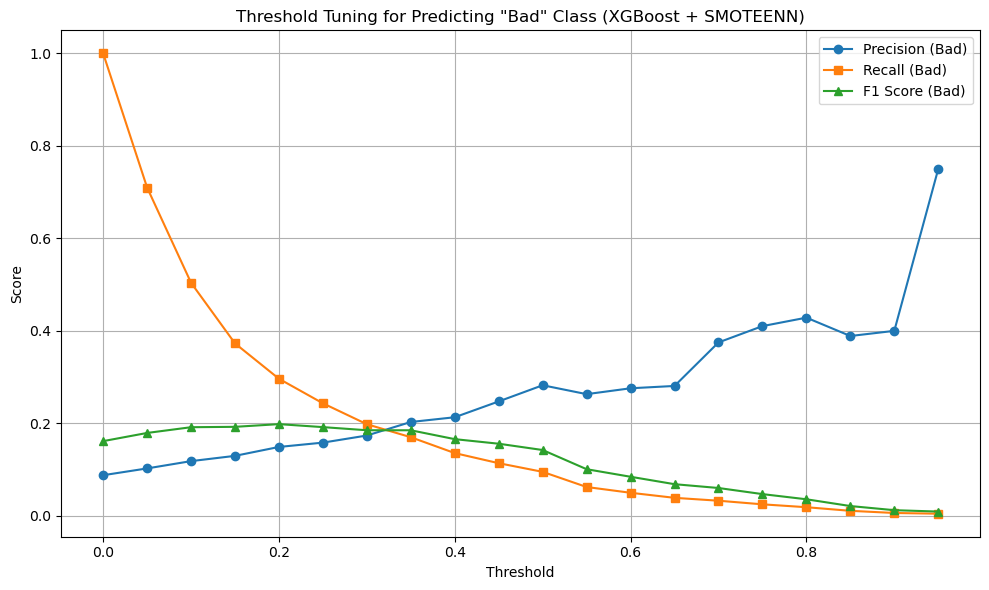


📌 Best threshold based on F1 Score: 0.20

Final Evaluation:

Accuracy: 0.7893582007679649
Confusion Matrix:
 [[ 190  451]
 [1085 5566]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.15      0.30      0.20       641
        Good       0.93      0.84      0.88      6651

    accuracy                           0.79      7292
   macro avg       0.54      0.57      0.54      7292
weighted avg       0.86      0.79      0.82      7292



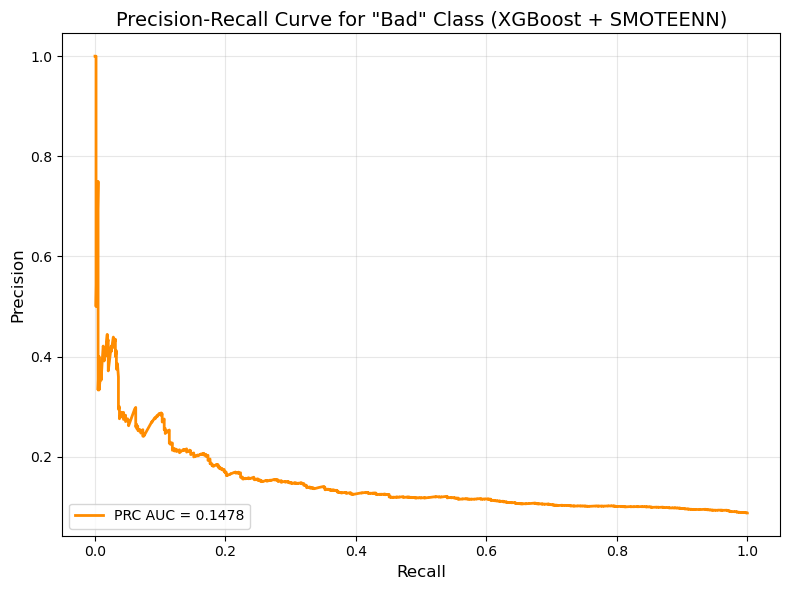

In [75]:
# XGBoost Tuning

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, accuracy_score, make_scorer)
import matplotlib.pyplot as plt

# Load datasets
train_df = pd.read_csv("train_set.csv")
test_df = pd.read_csv("test_set.csv")

# Define feature columns
feature_columns = [col for col in train_df.columns if col not in ["credit_status", "id"]]

# Prepare training and testing data
X_train = train_df[feature_columns]
X_test = test_df[feature_columns]
y_train = train_df["credit_status"]
y_test = test_df["credit_status"]

# Encode labels to 0 = Bad, 1 = Good
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
bad_index = list(le.classes_).index('Bad')  # Usually 0

# Apply SMOTEENN to training data
smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X_train, y_train_encoded)

# Define model
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1]  
}

# Scorer for F1 score on "Bad" class
scorer = make_scorer(f1_score, pos_label=bad_index)

# Grid search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit model on resampled data
grid_search.fit(X_resampled, y_resampled)
best_xgb = grid_search.best_estimator_

print("✅ Best Parameters:", grid_search.best_params_)

# Get predicted probabilities
y_probs = best_xgb.predict_proba(X_test)

# Threshold tuning
thresholds = np.arange(0, 1, 0.05)
precisions, recalls, f1s = [], [], []

print("\n🔎 Evaluating thresholds...\n")
for threshold in thresholds:
    y_pred = np.where(y_probs[:, bad_index] > threshold, 'Bad', 'Good')

    precision = precision_score(y_test, y_pred, pos_label='Bad', zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label='Bad', zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label='Bad', zero_division=0)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    print(f"Threshold: {threshold:.2f}")
    print(f"Precision (Bad): {precision:.4f}")
    print(f"Recall (Bad):    {recall:.4f}")
    print(f"F1 Score (Bad):  {f1:.4f}\n")

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision (Bad)', marker='o')
plt.plot(thresholds, recalls, label='Recall (Bad)', marker='s')
plt.plot(thresholds, f1s, label='F1 Score (Bad)', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning for Predicting "Bad" Class (XGBoost + SMOTEENN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final Evaluation with best F1 threshold
best_thresh = thresholds[np.argmax(f1s)]
y_final = np.where(y_probs[:, bad_index] > best_thresh, 'Bad', 'Good')

print(f"\n📌 Best threshold based on F1 Score: {best_thresh:.2f}")
print("\nFinal Evaluation:\n")
print("Accuracy:", accuracy_score(y_test, y_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_final))
print("Classification Report:\n", classification_report(y_test, y_final))

# Compute PRC for "Bad" class
precision_curve, recall_curve, _ = precision_recall_curve(y_test_encoded, y_probs[:, bad_index], pos_label=bad_index)
prc_auc = auc(recall_curve, precision_curve)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve for "Bad" Class (XGBoost + SMOTEENN)', fontsize=14)
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 8 candidates, totalling 24 fits

🔎 Evaluating thresholds based on F1 Score (Bad)...

Threshold: 0.00
Precision (Bad): 0.0879
Recall (Bad):    1.0000
F1 Score (Bad):  0.1616

Threshold: 0.05
Precision (Bad): 0.1144
Recall (Bad):    0.5086
F1 Score (Bad):  0.1868

Threshold: 0.10
Precision (Bad): 0.1227
Recall (Bad):    0.3604
F1 Score (Bad):  0.1830

Threshold: 0.15
Precision (Bad): 0.1294
Recall (Bad):    0.3011
F1 Score (Bad):  0.1811

Threshold: 0.20
Precision (Bad): 0.1393
Recall (Bad):    0.2668
F1 Score (Bad):  0.1830

Threshold: 0.25
Precision (Bad): 0.1493
Recall (Bad):    0.2418
F1 Score (Bad):  0.1846

Threshold: 0.30
Precision (Bad): 0.1529
Recall (Bad):    0.2075
F1 Score (Bad):  0.1760

Threshold: 0.35
Precision (Bad): 0.1479
Recall (Bad):    0.1700
F1 Score (Bad):  0.1582

Threshold: 0.40
Precision (Bad): 0.1514
Recall (Bad):    0.1498
F1 Score (Bad):  0.1506

Threshold: 0.45
Precision (Bad): 0.1525
Recall (Bad):    0.1232
F1 Score (Bad):  0.136

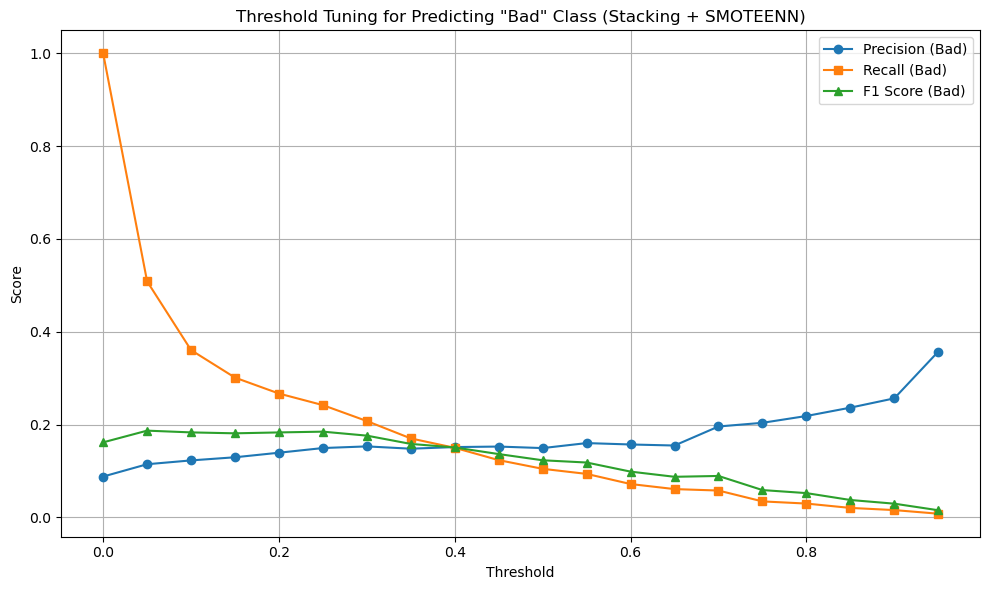

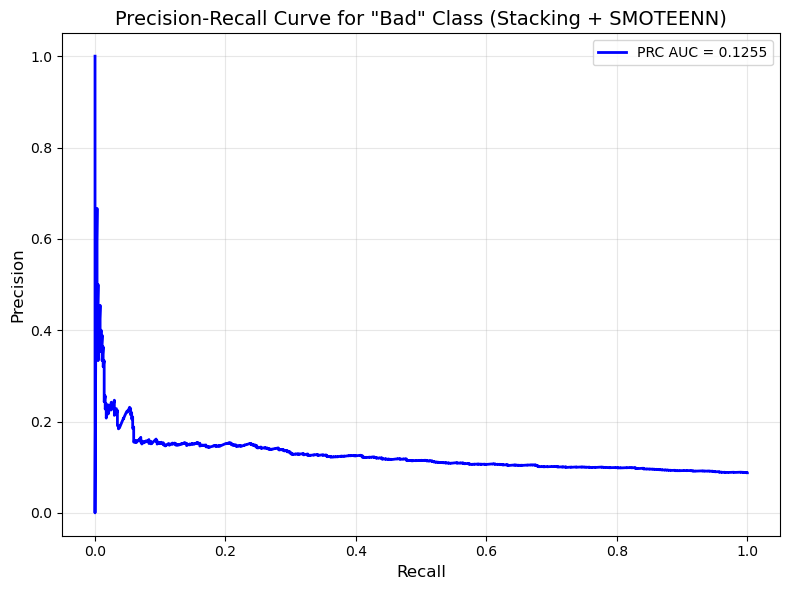


📌 Best threshold based on F1 Score (Bad): 0.05

Final Evaluation:

Accuracy: 0.6108063631376851
Confusion Matrix:
 [[ 326  315]
 [2523 4128]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.11      0.51      0.19       641
        Good       0.93      0.62      0.74      6651

    accuracy                           0.61      7292
   macro avg       0.52      0.56      0.47      7292
weighted avg       0.86      0.61      0.70      7292



In [64]:
# Stacking Model Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# Load data
train_df = pd.read_csv("train_set.csv")
test_df = pd.read_csv("test_set.csv")

# Define features and labels
feature_columns = [col for col in train_df.columns if col not in ["credit_status", "id"]]
X_train = train_df[feature_columns]
y_train = train_df["credit_status"]
X_test = test_df[feature_columns]
y_test = test_df["credit_status"]

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
bad_index = list(le.classes_).index('Bad')

# Define base learners
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss')

# Define final estimator
final_estimator = LogisticRegression(
    max_iter=10000,
    solver='lbfgs',
    random_state=42
)

# Create stacking classifier
stacking = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=final_estimator,
    passthrough=True,
    n_jobs=-1
)

# Combine SMOTEENN with stacking in a pipeline
pipeline = ImbPipeline(steps=[
    ('resample', SMOTEENN(random_state=42)),
    ('model', stacking)
])

# Define grid search parameters for base estimators
param_grid = {
    'model__rf__n_estimators': [100, 200],
    'model__rf__max_depth': [5, 10],
    'model__xgb__n_estimators': [100],
    'model__xgb__learning_rate': [0.05, 0.1]
}

# Grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='precision',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train_enc)
best_model = grid_search.best_estimator_

# Predict probabilities using best stacking model
y_probs = best_model.predict_proba(X_test)

# Threshold tuning
thresholds = np.arange(0, 1, 0.05)
precisions, recalls, f1s = [], [], []

print("\n🔎 Evaluating thresholds based on F1 Score (Bad)...\n")
for threshold in thresholds:
    y_pred = np.where(y_probs[:, bad_index] > threshold, 'Bad', 'Good')
    
    precision = precision_score(y_test, y_pred, pos_label='Bad', zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label='Bad', zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label='Bad', zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    print(f"Threshold: {threshold:.2f}")
    print(f"Precision (Bad): {precision:.4f}")
    print(f"Recall (Bad):    {recall:.4f}")
    print(f"F1 Score (Bad):  {f1:.4f}\n")

# Plot precision-recall-f1
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision (Bad)', marker='o')
plt.plot(thresholds, recalls, label='Recall (Bad)', marker='s')
plt.plot(thresholds, f1s, label='F1 Score (Bad)', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning for Predicting "Bad" Class (Stacking + SMOTEENN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute PRC and AUC for "Bad" class
precision_curve, recall_curve, _ = precision_recall_curve(y_test_enc, y_probs[:, bad_index], pos_label=bad_index)
prc_auc = auc(recall_curve, precision_curve)

# Plot PRC curve
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, color='blue', linewidth=2, label=f'PRC AUC = {prc_auc:.4f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve for "Bad" Class (Stacking + SMOTEENN)', fontsize=14)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Choose best threshold by F1 score
best_thresh = thresholds[np.argmax(f1s)]
y_final = np.where(y_probs[:, bad_index] > best_thresh, 'Bad', 'Good')

print(f"\n📌 Best threshold based on F1 Score (Bad): {best_thresh:.2f}")
print("\nFinal Evaluation:\n")
print("Accuracy:", accuracy_score(y_test, y_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_final))
print("Classification Report:\n", classification_report(y_test, y_final))

Fitting 3 folds for each of 48 candidates, totalling 144 fits

✅ Best Parameters: {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

✅ Best Threshold: 0.325 | F1: 0.350 | Precision: 0.284 | Recall: 0.457

🔍 Classification Report at Best Threshold:
              precision    recall  f1-score   support

        Good       0.94      0.89      0.92      6651
         Bad       0.28      0.46      0.35       641

    accuracy                           0.85      7292
   macro avg       0.61      0.67      0.63      7292
weighted avg       0.89      0.85      0.87      7292


🔍 Confusion Matrix:
[[5911  740]
 [ 348  293]]

📈 PRC AUC: 0.2559


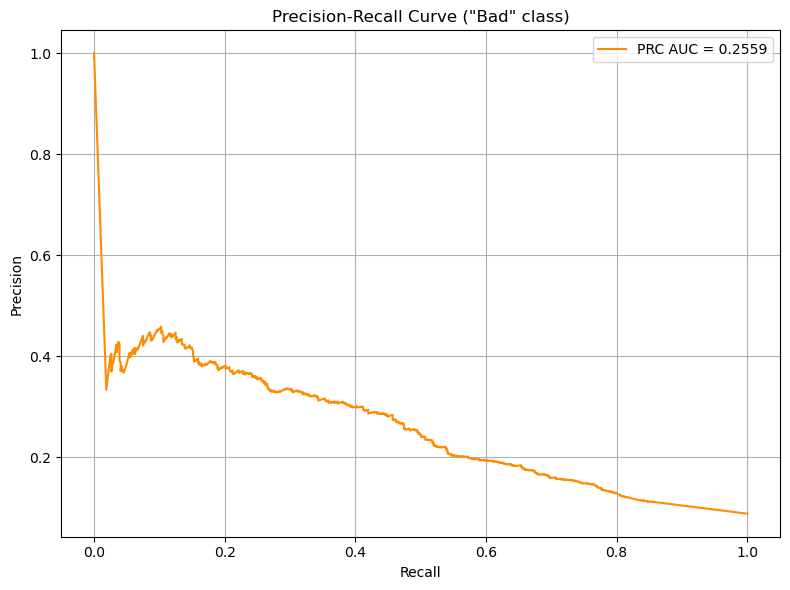


                                          Feature  Importance
0                                            age    0.167048
1                              log_annual_income    0.137943
2                             log_years_employed    0.117202
3                                    family_size    0.082891
4                education_type_Higher education    0.037046
5                                     own_realty    0.029710
6                          family_status_Married    0.027104
7   education_type_Secondary / secondary special    0.025271
8                            income_type_Working    0.023696
9                              occupation_Others    0.022673
10                                         phone    0.022080
11                                       own_car    0.021684
12                           occupation_Laborers    0.020866
13                                    work_phone    0.020270
14                                        gender    0.020256
15                hous

/var/folders/yk/vlzfvr0952z_d1jtd2jgn2tm0000gn/T/ipykernel_8796/413065554.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


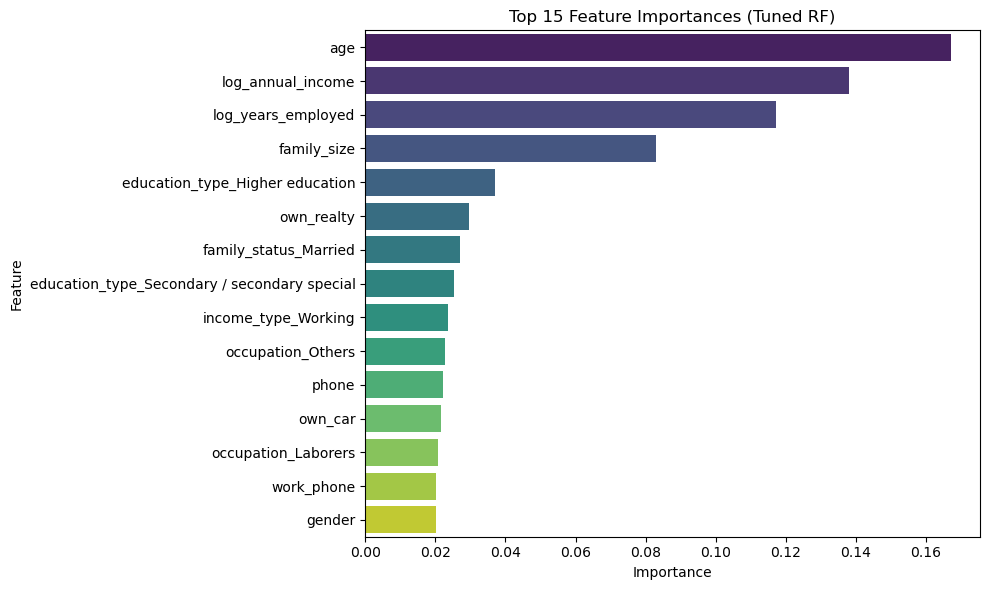

In [59]:
# Random Forest + BorderlineSMOTE + Threshold Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('train_set.csv')
test_set = pd.read_csv('test_set.csv')

# Encode target labels: 'Bad' -> 0, 'Good' -> 1
y_train = (train_set['credit_status'] == 'Good').astype(int)
y_test = (test_set['credit_status'] == 'Good').astype(int)

# Drop target and id
X_train = train_set.drop(['credit_status'], axis=1)
X_test = test_set.drop(['credit_status', 'id'], axis=1)

# Drop redundant features
redundant_features = ['annual_income', 'years_employed']
X_train_reduced = X_train.drop(columns=redundant_features)
X_test_reduced = X_test.drop(columns=redundant_features)

# Define pipeline
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Define parameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2']
}

# Grid search with F1 score for class 0 ("Bad")
f1_scorer = make_scorer(f1_score, pos_label=0)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=2
)

# Fit
grid_search.fit(X_train_reduced, y_train)
print("\n✅ Best Parameters:", grid_search.best_params_)

# Best pipeline
pipeline = grid_search.best_estimator_

# Predict probabilities for class 0 ("Bad")
y_proba = pipeline.predict_proba(X_test_reduced)[:, 0]

# Threshold tuning
precision, recall, thresholds = precision_recall_curve(1 - y_test, y_proba, pos_label=1)  # 1 - y_test makes 'Bad' = 1
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n✅ Best Threshold: {best_threshold:.3f} | F1: {f1_scores[best_idx]:.3f} | Precision: {precision[best_idx]:.3f} | Recall: {recall[best_idx]:.3f}")

# Apply threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)  # 1 = Bad

# Evaluation
print("\n🔍 Classification Report at Best Threshold:")
print(classification_report(1 - y_test, y_pred_custom, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(1 - y_test, y_pred_custom))

# PRC AUC
prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")

# PRC Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ("Bad" class)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train_reduced.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']
print("\n", feat_imp_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()